Solving environment: ...working... failed



PackagesNotFoundError: The following packages are not available from current channels:

  - axelrod

Current channels:

  - https://repo.continuum.io/pkgs/main/win-64
  - https://repo.continuum.io/pkgs/main/noarch
  - https://repo.continuum.io/pkgs/free/win-64
  - https://repo.continuum.io/pkgs/free/noarch
  - https://repo.continuum.io/pkgs/r/win-64
  - https://repo.continuum.io/pkgs/r/noarch
  - https://repo.continuum.io/pkgs/pro/win-64
  - https://repo.continuum.io/pkgs/pro/noarch
  - https://repo.continuum.io/pkgs/msys2/win-64
  - https://repo.continuum.io/pkgs/msys2/noarch




In [1]:
# %matplotlib inline
import pandas as pd
import glob
import itertools
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import axelrod as axl

In [2]:
# FUNCTIONS
def get_seq_str(seq,cooperate_val="C ",defect_val="D "):
    s=""
    for move in seq.split(","):
        s+=move.strip().replace("[","").replace("]","").replace("'","")
    
    s.replace("C",cooperate_val).replace("D",defect_val)
    return s

def get_char_seq(seq):
    chars = []
    for letter in seq:
        chars += letter
        
    return chars

def get_notation(seq, concat_len=0):
    if type(seq) is not list():
        seq = get_char_seq(seq)

    s = seq[0]
    pos = 0
    num_chars = 0
    for char in seq:
        if char == seq[pos]:
            num_chars += 1
        else:
            s += str(num_chars) + ","
            pos += num_chars
            num_chars = 1
            
        if pos+num_chars == len(seq):
            s += str(num_chars)
    
    if not concat_len == 0:
        s2=",".join(s.split(",")[:concat_len])
        if not s2 == s:
            s = s2+"..."
            
    return s

def distance(s1,s2):
    d = 0
    for i in range(len(s1)):
        if not s1[i] == s2[i]:
            d += 1
            
    return d

In [4]:
# # READ IN ALL FILES
# path =r'C:\Users\toby\Documents\notebooks\Project\output'
# all_files = glob.glob(path + "/*.csv")
# df_list = []
# for file in all_files:
#     opponent_name = file.split("\\")[-1].split(".csv")[0].split("FINAL-")[1].replace("(","").replace("$","")
#     opponent_df = pd.DataFrame.from_csv(file,index_col=None)
#     opponent_df.columns = ["generation", "mean_over_pop", "srt_var", "best_score","best_sequence"]
#     opponent_df["opponent_name"]=opponent_name
#     opponent_df.head()
#     df_list+=[opponent_df]
    
# df=pd.concat(df_list,ignore_index=True)

df = pd.DataFrame.from_csv("cached_df.csv")

C:\dev\tools\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
print(df.shape)
df.head()

(132600, 12)


,generation,mean_over_pop,srt_var,best_score,best_sequence,opponent_name,memory_depth,stochastic,score_bin,start_move,num_blocks,mean_block_len
0,1,2.9234,1.323829,5.0,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,phi,NaN,NaN,very high,D,1,200.0
1,2,4.4224,0.517859,5.0,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,phi,NaN,NaN,very high,D,1,200.0
2,3,4.8040,0.509651,5.0,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,phi,NaN,NaN,very high,D,1,200.0
3,4,4.8434,0.541578,5.0,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,phi,NaN,NaN,very high,D,1,200.0
4,5,4.7846,0.662354,5.0,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,phi,NaN,NaN,very high,D,1,200.0


# Clean and update clean data

In [5]:
# CLEANING DATA
clean_strings = []
char_strings = []
for seq in df["best_sequence"]:
    clean_string = get_seq_str(seq)
    clean_strings += [clean_string]

In [6]:
df["best_sequence"] = clean_strings

In [7]:
# Add Classifires on to main df
def get_classifiers(player_str:str):
    clean_str = player_str.replace("_","").split("@")[0]
    try:
        player_inst = eval("axl."+clean_str)()
        return player_inst.classifier
    except (AttributeError,SyntaxError) as e:
#         print("could not find palyer:", clean_str)
        return None

classifiers = dict()
for name in df["opponent_name"].unique():
    classifiers[name]= get_classifiers(name)

In [8]:
df_classifiers = pd.DataFrame.from_dict(classifiers)
df_classifiers=df_classifiers.transpose()
print("# of opponents with classifiers found:",len(df_classifiers.dropna()))
df_classifiers["opponent_name"] = df_classifiers.index

length of found: 168


In [9]:
# these are really the only informative ones
df_classifiers = df_classifiers[["memory_depth","stochastic","opponent_name"]]
df = df.merge(df_classifiers,how='left')

In [10]:
#creating score bins for data
df["score_bin"]=pd.cut(df["best_score"],5, labels=["very low","low", "medium", "high", "very high"])

In [12]:
# Find basic descriptions for numbers in the sequence
start_move = list()
num_blocks = list()
mean_block_len = list()
for seq in df["best_sequence"]:
    notation_str = get_notation(seq)
    start_move += list(notation_str[0])
    
    split = notation_str.split(",")
    num_blocks.append(len(split))
    
    #clean initial string for casting
    split[0] = split[0].replace(notation_str[0],"")   
    #cast to ints for mean
    split = np.array([int(x) for x in split])
    mean_block_len.append(split.mean())
    

In [13]:
df["start_move"] = start_move
df["num_blocks"] = num_blocks
df["mean_block_len"] = mean_block_len

In [14]:
print(df.shape)
df.head()

(132600, 12)


,generation,mean_over_pop,srt_var,best_score,best_sequence,opponent_name,memory_depth,stochastic,score_bin,start_move,num_blocks,mean_block_len
0,1,2.9234,1.323829,5.0,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,phi,None,None,very high,D,1,200.0
1,2,4.4224,0.517859,5.0,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,phi,None,None,very high,D,1,200.0
2,3,4.8040,0.509651,5.0,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,phi,None,None,very high,D,1,200.0
3,4,4.8434,0.541578,5.0,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,phi,None,None,very high,D,1,200.0
4,5,4.7846,0.662354,5.0,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,phi,None,None,very high,D,1,200.0


In [6]:
df["generation"].unique().max()

600

In [ ]:
# Cache the df to csv:
df.to_csv("cached_df.csv")

In [7]:
df.describe()

,generation,mean_over_pop,srt_var,best_score,memory_depth,num_blocks,mean_block_len
count,132600.000000,132600.000000,132600.000000,132600.000000,1.008000e+05,132600.000000,132600.000000
mean,300.500000,3.248470,0.457537,3.541558,inf,39.467036,58.502200
std,173.205493,0.844024,0.253548,0.813183,NaN,48.779972,70.737725
min,1.000000,0.494800,0.070654,1.000000,0.000000e+00,1.000000,1.000000
25%,150.750000,2.875600,0.273004,3.100000,3.000000e+00,2.000000,2.941176
50%,300.500000,3.031200,0.417396,3.300000,inf,6.000000,33.333333
75%,450.250000,3.750850,0.587246,4.000000,inf,68.000000,100.000000
max,600.000000,4.958800,2.012142,5.000000,inf,200.000000,200.000000


# Build new Data Structures

In [107]:
#Selecting only the best sequences (by score)
df_generation_max = df.loc[df['generation'] == df["generation"].unique().max()]
df_generation_max = df_generation_max.sort_values(by='best_score')

# Group by opponents 
df_by_opponent = df_generation_max.groupby("opponent_name")

# Group by sequences
df_by_sequence = df_generation_max.groupby("best_sequence")

# Group by stochastic
df_by_stochastic = df_generation_max.groupby("stochastic")

## Group by stochastic
df_by_bins = df_generation_max.groupby("score_bin")

# Data Checking

In [10]:
df["stochastic"].value_counts()

False    68400
True     32400
Name: stochastic, dtype: int64

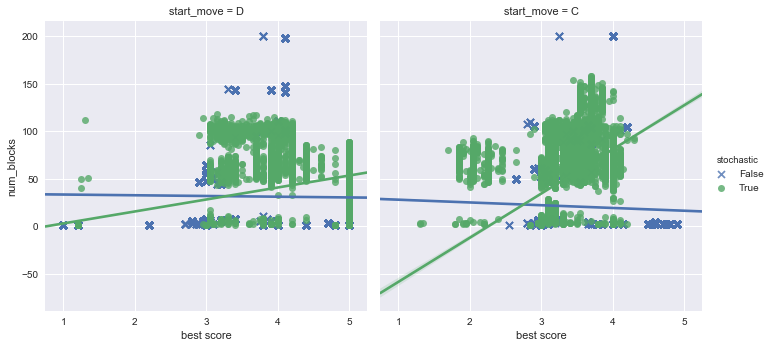

In [21]:
g = sns.lmplot(x="best_score", y="num_blocks",col="start_move", data=df, hue="stochastic", markers=["x","o"],legend=True)
g.set_axis_labels("best score", "num_blocks")

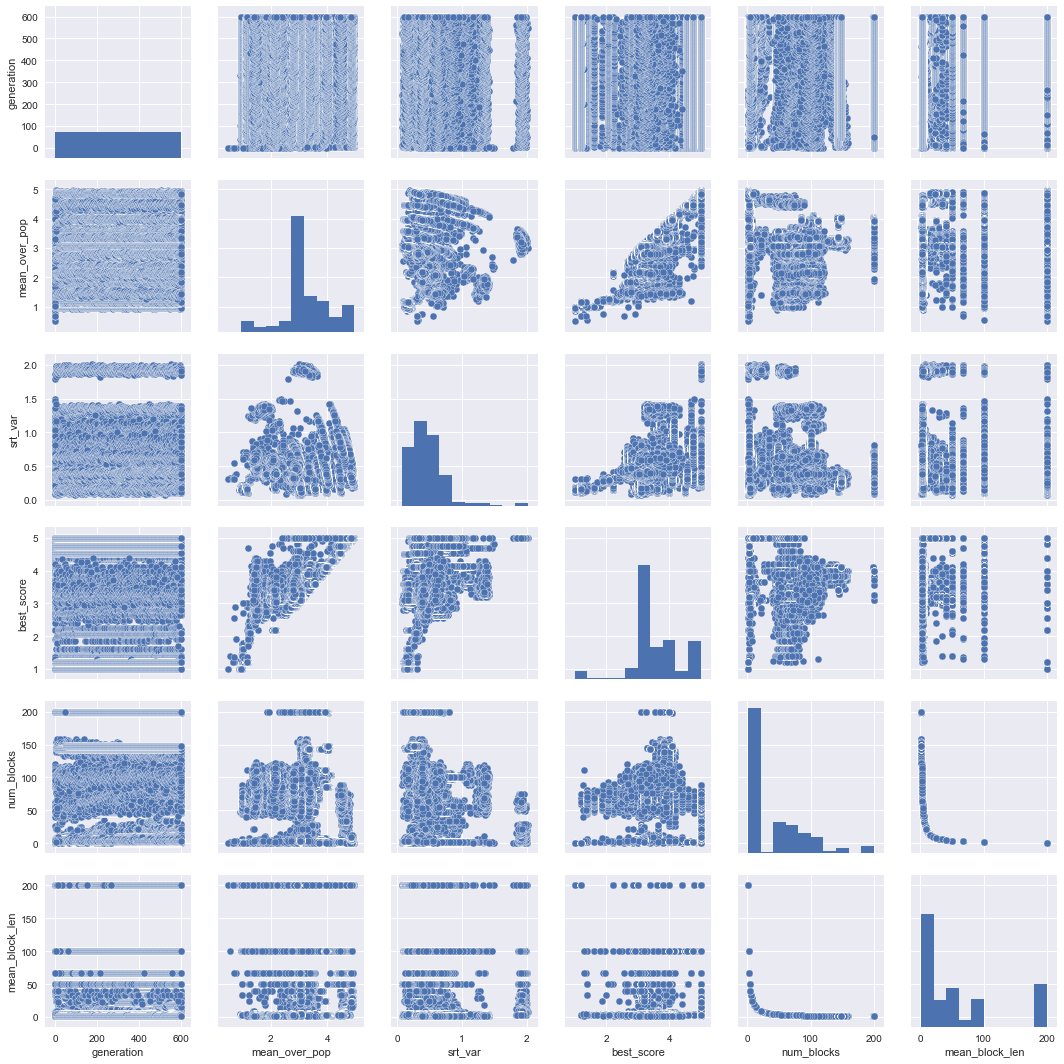

In [20]:
plot_df = df[['generation', 'mean_over_pop', 'srt_var', 'best_score','num_blocks', 'mean_block_len']]
plot = sns.pairplot(plot_df)

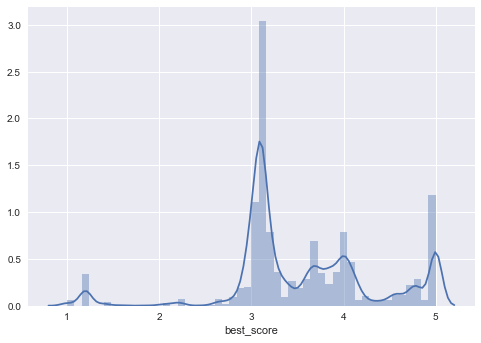

In [22]:
plot = sns.distplot(df["best_score"])

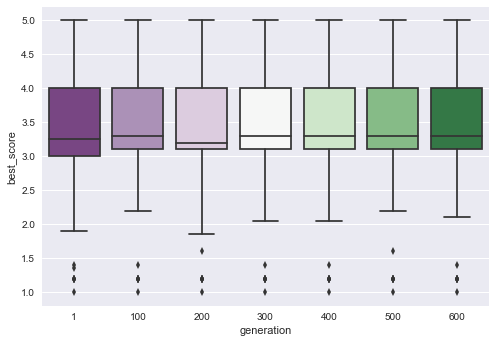

In [25]:
plot_df = df.loc[df["generation"].isin([1,100,200,300,400,500,600])]
sns.boxplot(x="generation", y="best_score", data=plot_df, palette="PRGn")

# Analysis - General
Questions:
 1. What does the distance matrix look like for the solution?
 2. What types of opponent are beaten by each solution?
 3. What are there any score that lots of opponents have
 4. What are there any common patterns between different types of opponents?
 5. Is there some sort of "order" between stratergys? if so is there a pattern on what to play to beat them?


# 1. What does the distance matrix look like for the solution?

In [51]:
def _gen_matrix(in_all_sequences):
    m = []
    for i in range(len(in_all_sequences)):
        seq_i = in_all_sequences[i]
        seq_i_comparisons = []
        for j in  range(len(in_all_sequences)):
            seq_j = in_all_sequences[j]
            seq_i_comparisons += [distance(seq_i,seq_j)]
    
        m += [seq_i_comparisons]
    
    return np.matrix(m)

In [52]:
all_sequences = list(df_generation_max.sort_values("opponent_name")["best_sequence"])
M1 = _gen_matrix(all_sequences)

all_sequences = list(df_generation_max.sort_values("best_score")["best_sequence"])
M2 = _gen_matrix(all_sequences)

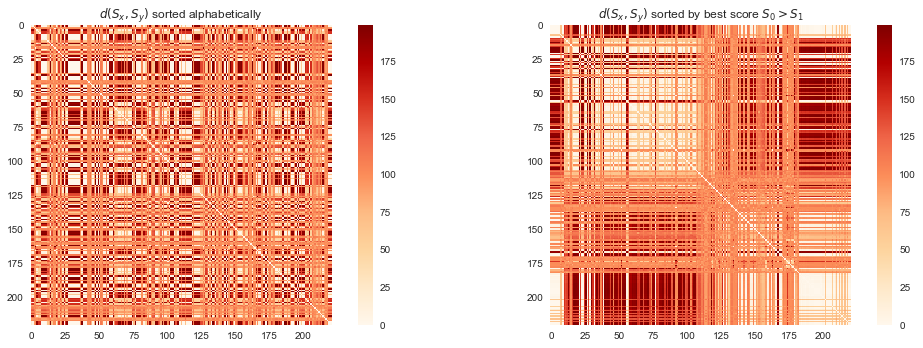

In [62]:
# Very slow, look into prettying up
# f, ax = plt.subplots(figsize=(9, 6))
# sns.heatmap(M, annot=True, fmt="d", linewidths=.5,ax=ax)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(M1, cmap='OrRd')
plt.colorbar()
plt.grid(False)
plt.title("$d(S_x,S_y)$ sorted alphabetically")

plt.subplot(122)
plt.imshow(M2, cmap='OrRd')
plt.colorbar()
plt.grid(False)
plt.title("$d(S_x,S_y)$ sorted by best score $S_0>S_1$")

plt.tight_layout()

There isnt much of a pattern alpabetically (as would be expected). By score it can be seen by the dar patches in the top-right and bottom-left corers that the best and worst scoring opponents have a higher distance score. i.e for the bottom left; these are comparing high scoring $x$ opponentes against low scoring $y$ opponents. They have a much higher distence than the bottom-right, whos scores are all low.

Another point is that the top-left, comparing high scoring to high scoring, is much more varied than the bottom-right. This is showing that there is a high variation to scoring high; whereas not much to score low. This may be due to the high number of $D200$ solutions, or the complexity of the soutions being high (the goal of building a high number of unpunished deffections) is high. 

What about looking into how the distances compare between different score bins:

In [128]:
M=dict()
for lab, df in df_by_bins:
    print(lab, "|with",len(df), "opponents")
    print(df["best_score"].min(),"->",df["best_score"].max())
    sequence_list = list(df.sort_values("best_score")["best_sequence"])
    M[lab] = (_gen_matrix(sequence_list))
    

very low |with 8 opponents
1.0 -> 1.4
low |with 2 opponents
2.1 -> 2.2
medium |with 111 opponents
2.65 -> 3.4
high |with 62 opponents
3.45 -> 4.2
very high |with 38 opponents
4.3 -> 5.0


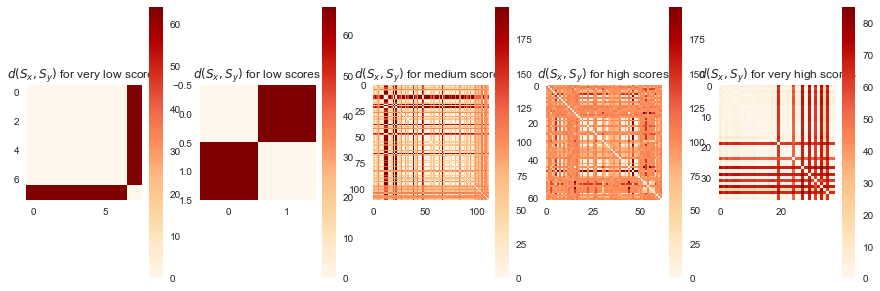

In [142]:
i=1
plt.figure(figsize=(15,5))

for key in M.keys():
    plt.subplot(150+i)
    plt.imshow(M[key], cmap='OrRd')
    plt.colorbar()
    plt.grid(False)
    plt.title("$d(S_x,S_y)$ for "+key +" scores")
    i+=1

In [145]:
for seq in df_generation_max.sort_values("best_score")[:20]["best_sequence"]:
    print(get_notation(seq,4), "("+str(len(get_notation(seq).split(",")))+")")

D200 (1)
D200 (1)
D200 (1)
D200 (1)
D200 (1)
D200 (1)
D200 (1)
D23,1,8,1... (70)
C5,25,2,2... (78)
D200 (1)
C19,1,80,3... (50)
C19,1,7,1... (78)
C19,1,3,1... (72)
D3,16,1,179... (5)
D2,17,1,80... (46)
C2,1,3,1... (106)
C1,2,16,1... (60)
C19,1,179,1 (4)
C19,1,133,1... (6)
D2,17,1,178... (5)


# 2. What types of opponent are beaten by each solution?

In [19]:
print("There are",len(df_generation_max["best_sequence"].unique()),"different sequences")
print("These are:")

for seq in df_generation_max["best_sequence"].unique():
    seq_list = list(df_generation_max["opponent_name"].loc[df_generation_max["best_sequence"]==seq])
    print(get_notation(seq,6), "for", len(seq_list), "opponent(s):")
    for op in seq_list:
        score = str(df_generation_max["best_score"].loc[df_generation_max["opponent_name"]==op].max())
        print("\t-",op, "(score: "+score+")")

There are 142 different sequences
These are:
D200 for 36 opponent(s):
	- Defector (score: 1.0)
	- Meta_Winner@_199_players (score: 1.2)
	- Meta_Winner_Long_Memory@_113_players (score: 1.2)
	- Meta_Winner_Memory_One@_35_players (score: 1.2)
	- Meta_Winner_Finite_Memory@_86_players (score: 1.2)
	- Meta_Winner_Deterministic@_137_players (score: 1.2)
	- Meta_Winner_Stochastic@_62_players (score: 1.2)
	- Cycler_DDC (score: 2.2)
	- Prober_4 (score: 3.0)
	- Desperate (score: 3.0)
	- Alternator (score: 3.0)
	- ThueMorseInverse (score: 3.0)
	- ThueMorse (score: 3.0)
	- Cycler_DC (score: 3.0)
	- Colbert (score: 3.6)
	- Cycler_CCCDCD (score: 3.8)
	- AntiCycler (score: 3.8)
	- Cycler_CCD (score: 3.8)
	- Cycler_CCCD (score: 4.0)
	- Cycler_CCCCCD (score: 4.4)
	- Fool_Me_Forever (score: 4.8)
	- Meta_Minority@_199_players (score: 4.8)
	- EasyGo (score: 4.8)
	- Bully (score: 4.8)
	- pi (score: 5.0)
	- e (score: 5.0)
	- Math_Constant_Hunter (score: 5.0)
	- Anti_Tit_For_Tat (score: 5.0)
	- Cooperator (sc

In [20]:
df_generation_max["best_sequence"].value_counts()
df_generation_max.loc[df_generation_max["best_sequence"]=="CCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCDDDDDDDDDD"]

,generation,mean_over_pop,srt_var,best_score,best_sequence,opponent_name
115799,600,3.0152,0.260056,3.1,CCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCCCCC...,Tit_For_Tat
63599,600,2.8582,0.675309,3.1,CCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCCCCC...,MEM2
61799,600,2.8738,0.638219,3.1,CCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCCCCC...,"Limited_Retaliate_2@_0.08,_15"
77999,600,2.9326,0.563371,3.1,CCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCCCCC...,NMWE_Deterministic@_137_players
43199,600,2.9612,0.365834,3.1,CCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCCCCC...,"General_Soft_Grudger@_n=1,d=4,c=2"
4199,600,3.0262,0.228918,3.1,CCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCCCCC...,Adaptive_Tit_For_Tat@_0.5


# 3. What are there any score that lots of opponents have

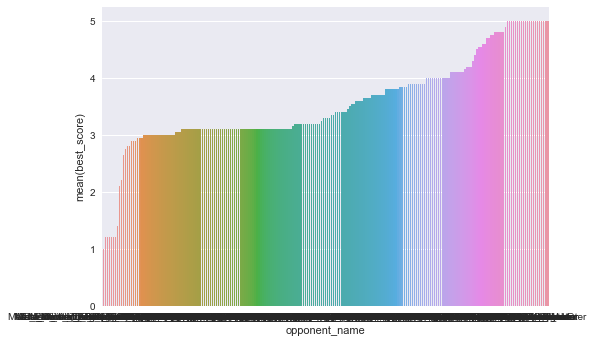

In [21]:
# Set up the matplotlib figure
sns.set(style="darkgrid")
x = sns.barplot(x="opponent_name",y="best_score",data=df_generation_max)

It looks like for the majority of opponents we can score +3 against them. ie, Cooperate more than we defect. Whats interesting is the plateaus that can be seen across the spectrum. There seem to be lots of noticable flat areas such as around 3, 4 and 5. 

In [22]:
print("There are",len(df_generation_max["best_score"].unique()),"different best scores")
print("These are:")

for score in df_generation_max["best_score"].unique():
    score_list = list(df_generation_max["opponent_name"].loc[df_generation_max["best_score"]==score])
    print(score, "for", len(score_list), "opponent(s):")
    for op in score_list:
        sequence = get_notation(df_generation_max["best_sequence"].loc[df_generation_max["opponent_name"]==op],5)
        print("\t-",op, "("+sequence+")")

There are 42 different best scores
These are:
1.0 for 1 opponent(s):
	- Defector (D200)
1.2 for 6 opponent(s):
	- Meta_Winner@_199_players (D200)
	- Meta_Winner_Long_Memory@_113_players (D200)
	- Meta_Winner_Memory_One@_35_players (D200)
	- Meta_Winner_Finite_Memory@_86_players (D200)
	- Meta_Winner_Deterministic@_137_players (D200)
	- Meta_Winner_Stochastic@_62_players (D200)
1.4 for 1 opponent(s):
	- Better_and_Better (D23,1,8,1,8...)
2.1 for 1 opponent(s):
	- Meta_Winner_Ensemble@_199_players (C5,25,2,2,1...)
2.2 for 1 opponent(s):
	- Cycler_DDC (D200)
2.65 for 1 opponent(s):
	- Aggravater (C19,1,80,3,3...)
2.75 for 1 opponent(s):
	- ZD-Extort-4@_0.23529411764705882,_0.25,_1 (C19,1,7,1,8...)
2.8 for 2 opponent(s):
	- Fortress4 (D3,16,1,179,1)
	- ZD-Extortion@_0.2,_0.1,_1 (C19,1,3,1,6...)
2.9 for 3 opponent(s):
	- Fortress3 (D2,17,1,80,2...)
	- DoubleResurrection (C2,1,3,1,5...)
	- TF2 (C1,2,16,1,80...)
2.95 for 3 opponent(s):
	- Suspicious_Tit_For_Tat (C19,1,179,1)
	- SolutionB5 (C1

# 4. Is there some sort of "order" between stratergys? if so is there a pattern on what to play to beat them?

In [64]:
df_by_stochastic.describe().transpose()

stochastic                False       True 
best_score    count  114.000000   54.000000
              mean     3.573246    3.415741
              std      0.789454    1.004369
              min      1.000000    1.200000
              25%      3.100000    3.100000
              50%      3.200000    3.200000
              75%      4.100000    3.900000
              max      5.000000    5.000000
generation    count  114.000000   54.000000
              mean   600.000000  600.000000
              std      0.000000    0.000000
              min    600.000000  600.000000
              25%    600.000000  600.000000
              50%    600.000000  600.000000
              75%    600.000000  600.000000
              max    600.000000  600.000000
mean_over_pop count  114.000000   54.000000
              mean     3.426961    3.002237
              std      0.781718    0.887428
              min      0.947800    1.139200
              25%      2.908250    2.794200
              50%      3.054900    2.979200
              75%      3.887800    3.343850
              max      4.947200    4.691400
srt_var       count  114.000000   54.000000
              mean     0.447878    0.474842
              std      0.197508    0.364563
              min      0.142279    0.115655
              25%      0.299566    0.271222
              50%      0.432776    0.360550
              75%      0.592895    0.562729
              max      1.250665    1.957203

# 5. Are there any intresting results to the range of best scores?

In [65]:
sns.hist

<module 'seaborn' from 'C:\\dev\\tools\\Anaconda\\lib\\site-packages\\seaborn\\__init__.py'>